In [46]:
import os
import glob
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from numpy import asarray
np.set_printoptions(precision=5)#show 5 number after decimal point 

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.optimizers import Adam

In [47]:
base_dir = r"data"  # Define your base directory
label = []       # Labels for each category
images_path = [] # Paths of all images
all_images = []  # Names of all images
img_label = []   # Labels corresponding to each image

for directory in os.listdir(base_dir):
    if os.path.isdir(os.path.join(base_dir, directory)):
        label.append(directory)
        # Using glob to find all jpg, jpeg, and png files
        for img_path in glob.glob(os.path.join(base_dir, directory, '*.jpg')) + \
                        glob.glob(os.path.join(base_dir, directory, '*.jpeg')) + \
                        glob.glob(os.path.join(base_dir, directory, '*.png')):
            img_name = os.path.basename(img_path)
            all_images.append(img_name)
            images_path.append(img_path)
            img_label.append(directory)

In [48]:
def upload_data(vehicle_dir, non_vehicle_dir):
    data_in_matrix = []
    
    for img_name in tqdm(os.listdir(vehicle_dir)):
        img_path = os.path.join(vehicle_dir, img_name)
        image = Image.open(img_path)  # No conversion to 'L' here
        image_array = np.asarray(image)
        data_in_matrix.append([image_array, 1]) 

    # Upload non-vehicle images
    for img_name in tqdm(os.listdir(non_vehicle_dir)):
        img_path = os.path.join(non_vehicle_dir, img_name)
        image = Image.open(img_path)  # No conversion to 'L' here
        image_array = np.asarray(image)
        data_in_matrix.append([image_array, 0])  

    # Convert data to a NumPy array
    data_in_matrix = np.array(data_in_matrix, dtype=object)
    
    return data_in_matrix

# Define the paths
vehicles_url = r"data\vehicles"
non_vehicles_url = r"data\non-vehicles"

In [49]:
data_in_matrix = upload_data(vehicles_url, non_vehicles_url)

100%|████████████████████████████████████████████████████████████████████████████| 8968/8968 [00:02<00:00, 3275.07it/s]


In [50]:
# Save the data_in_matrix variable
np.save('data_in_matrix.npy',data_in_matrix)

In [51]:
# Load the data_in_matrix variable
data_in_matrix = np.load('data_in_matrix.npy',allow_pickle=True)

In [52]:
def extract_features_labels(data):
    X = []
    y = []

    for image_array, label in data:
        X.append(image_array)
        y.append(label)

    X = np.array(X)
    y = np.array(y)

    return X, y


In [53]:
# Extract features (X) and labels (y)
mat_x, mat_y = extract_features_labels(data_in_matrix)

In [54]:
mat_x = mat_x/255.0

In [55]:
#split the data to train and test 
X_train_mat, X_test_mat, y_train_mat, y_test_mat = train_test_split(mat_x,mat_y, test_size=0.2, random_state=42)
#split the train
X_train_mat, X_val_mat, y_train_mat, y_val_mat = train_test_split(X_train_mat,y_train_mat, test_size=0.2, random_state=42)

In [56]:
img_shape = cv2.imread(images_path[0])

print(f"Labels : { label}")
print(f"Total Images : {len(all_images)}")
print(f" Images shape : {img_shape.shape}")

Labels : ['non-vehicles', 'vehicles']
Total Images : 17760
 Images shape : (64, 64, 3)


In [57]:
data =pd.DataFrame({'image':images_path,'label':img_label}) 
data.head()

,image,label
0,data\non-vehicles\extra1.png,non-vehicles
1,data\non-vehicles\extra10.png,non-vehicles
2,data\non-vehicles\extra100.png,non-vehicles
3,data\non-vehicles\extra1000.png,non-vehicles
4,data\non-vehicles\extra1001.png,non-vehicles


In [58]:
data = data.sample(frac=1).reset_index()
data.head()

,index,image,label
0,7564,data\non-vehicles\image3245.png,non-vehicles
1,16136,data\vehicles\left (430).png,vehicles
2,7636,data\non-vehicles\image331.png,non-vehicles
3,11149,data\vehicles\2965.png,vehicles
4,5577,data\non-vehicles\image1457.png,non-vehicles


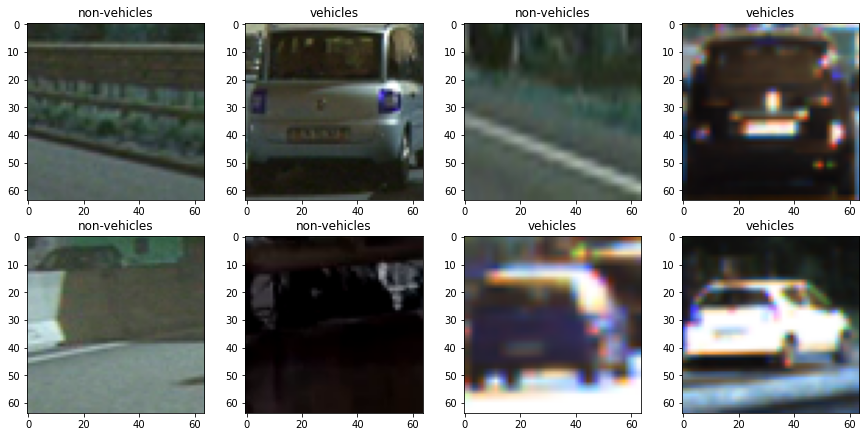

In [59]:
fig = plt.figure(figsize=(15,15))

for i in range(8):
    fig.add_subplot(4,4,i+1).set_title(data['label'][i])
    img = cv2.imread(data['image'][i])
    plt.imshow(img)
    
plt.show()

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17760 entries, 0 to 17759
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   17760 non-null  int64 
 1   image   17760 non-null  object
 2   label   17760 non-null  object
dtypes: int64(1), object(2)
memory usage: 416.4+ KB


In [61]:
data['label'].value_counts()

non-vehicles    8968
vehicles        8792
Name: label, dtype: int64

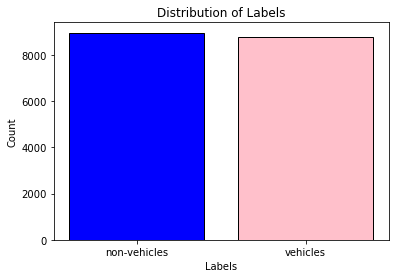

In [62]:
value_counts = data['label'].value_counts()

# Plotting
plt.bar(value_counts.index, value_counts.values, color=['blue', 'pink'],linewidth=1, edgecolor="black")
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()


### As we can see the data is more or less equally distributed.

In [63]:
X = data.drop('index',axis=1)
Y = data.label

In [64]:
X.head()

,image,label
0,data\non-vehicles\image3245.png,non-vehicles
1,data\vehicles\left (430).png,vehicles
2,data\non-vehicles\image331.png,non-vehicles
3,data\vehicles\2965.png,vehicles
4,data\non-vehicles\image1457.png,non-vehicles


In [65]:
X_train, X_final_test, y_train, y_final_test = train_test_split(X,Y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_final_test.shape)

(14208, 2)
(3552, 2)


In [66]:
y_train

15610    non-vehicles
5230         vehicles
15224        vehicles
83       non-vehicles
14570        vehicles
             ...     
11284    non-vehicles
11964    non-vehicles
5390         vehicles
860      non-vehicles
15795    non-vehicles
Name: label, Length: 14208, dtype: object

In [67]:
# Before we try real models, we will try a dummyClassifier. we will try to get high score than the dummyModel.
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train_mat, y_train_mat)
y_pred = dummy_clf.predict(X_val_mat)
print("The DummyClassifier score is:" ,round(accuracy_score(y_pred,y_val_mat),3))

The DummyClassifier score is: 0.497


In [21]:
# Define logistic regression model 
class LogisticRegression(tf.keras.Model):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.flatten = tf.keras.layers.Flatten(input_shape=(64, 64))  # Flatten input images
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation

    def call(self, x):
        x = self.flatten(x)
        return self.dense(x)

# Create an instance of the logistic regression model
model = LogisticRegression()

# Define your own learning rate
learning_rate = 0.001

# Create an optimizer with the specified learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Compile the model
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_mat, y_train_mat, epochs=50, batch_size=32, validation_data=(X_val_mat, y_val_mat))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_mat, y_test_mat)

print("Test Accuracy:", test_acc)

# Predictions on the test set
y_pred_prob = model.predict(X_test_mat)

# Convert probabilities to class labels based on a threshold (e.g., 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test_mat, y_pred)
print("Accuracy Score:", accuracy)


Epoch 1/50


356/356 [==============================] - 6s 6ms/step - loss: 0.4226 - accuracy: 0.8232 - val_loss: 0.3060 - val_accuracy: 0.8937
Epoch 2/50
356/356 [==============================] - 2s 4ms/step - loss: 0.3156 - accuracy: 0.8775 - val_loss: 0.2699 - val_accuracy: 0.9050
Epoch 3/50
356/356 [==============================] - 2s 4ms/step - loss: 0.2717 - accuracy: 0.8967 - val_loss: 0.3032 - val_accuracy: 0.8839
Epoch 4/50
356/356 [==============================] - 2s 5ms/step - loss: 0.2718 - accuracy: 0.8961 - val_loss: 0.2439 - val_accuracy: 0.9141
Epoch 5/50
356/356 [==============================] - 1s 4ms/step - loss: 0.2391 - accuracy: 0.9099 - val_loss: 0.2433 - val_accuracy: 0.9110
Epoch 6/50
356/356 [==============================] - 2s 4ms/step - loss: 0.2344 - accuracy: 0.9118 - val_loss: 0.2613 - val_accuracy: 0.8994
Epoch 7/50
356/356 [==============================] - 1s 4ms/step - loss: 0.2241 - accuracy: 0.9147 - val_loss: 0.3275 - val_accuracy: 0.8614
Epo

In [33]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score

# Function to create and compile the model with given hyperparameters
def build_and_compile_model(learning_rate):
    model = LogisticRegression()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter search space
learning_rates = np.logspace(-4, 0, 20)
batch_sizes = [16, 32, 64, 128]
n_iterations = 10  # Number of random search iterations

best_accuracy = 0
best_hyperparams = {}

for i in range(n_iterations):
    # Randomly pick a set of hyperparameters
    lr = np.random.choice(learning_rates)
    batch_size = np.random.choice(batch_sizes)

    # Build and compile the model
    model = build_and_compile_model(lr)

    # Train the model
    model.fit(X_train_mat, y_train_mat, epochs=50, batch_size=batch_size, verbose=0)

    # Evaluate the model
    _, accuracy = model.evaluate(X_val_mat, y_val_mat, verbose=0)

    # Check if this is the best model so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_hyperparams = {'learning_rate': lr, 'batch_size': batch_size}
        print(f"New best model found: Accuracy = {best_accuracy}, Hyperparameters = {best_hyperparams}")

print(f"Best model: Accuracy = {best_accuracy}, Hyperparameters = {best_hyperparams}")


New best model found: Accuracy = 0.9211822748184204, Hyperparameters = {'learning_rate': 0.002976351441631319, 'batch_size': 32}
New best model found: Accuracy = 0.935960590839386, Hyperparameters = {'learning_rate': 0.0018329807108324356, 'batch_size': 32}
New best model found: Accuracy = 0.9401829838752747, Hyperparameters = {'learning_rate': 0.00042813323987193956, 'batch_size': 32}
Best model: Accuracy = 0.9401829838752747, Hyperparameters = {'learning_rate': 0.00042813323987193956, 'batch_size': 32}


Best Hyperparameters: 'learning_rate': 0.00042813323987193956, 'batch_size': 32

In [32]:
# Define the neural network model
model = Sequential([
    Flatten(input_shape=(64, 64, 3)),  # Flatten the input images
    Dense(128, activation='relu'),     # Dense layer with 128 neurons and ReLU activation
    Dropout(0.5),                       # Dropout layer with dropout rate of 0.5
    Dense(64, activation='relu'),      # Dense layer with 64 neurons and ReLU activation
    Dense(1, activation='sigmoid')      # Output layer with 1 neuron and sigmoid activation for binary classification
])

# Compile the model
model.compile(optimizer='adam',     # Adam optimizer
              loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
              metrics=['accuracy'])        # Monitor accuracy during training

# Print model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 12288)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               1572992   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1581313 (6.03 MB)
Trainable params: 1581313 (6.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
# Train the model
history = model.fit(X_train_mat, y_train_mat, epochs=50, batch_size=32, validation_data=(X_val_mat, y_val_mat))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_val_mat, y_val_mat)
print("Test Loss:", test_loss)
print("Test Accuracy:",test_accuracy)

Epoch 1/50
356/356 [==============================] - 5s 13ms/step - loss: 0.4955 - accuracy: 0.7794 - val_loss: 0.3376 - val_accuracy: 0.8853
Epoch 2/50
356/356 [==============================] - 5s 13ms/step - loss: 0.3961 - accuracy: 0.8219 - val_loss: 0.2870 - val_accuracy: 0.9050
Epoch 3/50
356/356 [==============================] - 4s 12ms/step - loss: 0.3794 - accuracy: 0.8245 - val_loss: 0.2794 - val_accuracy: 0.9025
Epoch 4/50
356/356 [==============================] - 4s 12ms/step - loss: 0.3774 - accuracy: 0.8239 - val_loss: 0.2843 - val_accuracy: 0.9022
Epoch 5/50
356/356 [==============================] - 4s 12ms/step - loss: 0.3473 - accuracy: 0.8463 - val_loss: 0.2983 - val_accuracy: 0.8916
Epoch 6/50
356/356 [==============================] - 4s 12ms/step - loss: 0.3472 - accuracy: 0.8482 - val_loss: 0.2632 - val_accuracy: 0.9001
Epoch 7/50
356/356 [==============================] - 5s 13ms/step - loss: 0.3286 - accuracy: 0.8611 - val_loss: 0.2307 - val_accuracy: 0.9177

In [42]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu', input_shape = (64,64,3)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation = "relu"))
model.add(Dense(2, activation = "softmax"))

In [43]:
model.compile(optimizer = 'adam', loss= "categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 16, 16, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_14 (Flatten)        (None, 16384)             0         
                                                                 
 dense_51 (Dense)            (None, 512)             

In [44]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1)

In [28]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 25,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [38]:
training_set = train_datagen.flow_from_dataframe(
    dataframe = X_train,
    x_col = "image",
    y_col = "label",
    target_size = (64, 64),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "training")

validation_set = train_datagen.flow_from_dataframe(
    dataframe = X_train,
    x_col = "image",
    y_col = "label",
    target_size = (64, 64),
    color_mode ="rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "validation")

test_set = test_datagen.flow_from_dataframe(
    dataframe = X_final_test,
    x_col = "image",
    y_col = "label",
    target_size = (64, 64),
    color_mode ="rgb",
    class_mode = "categorical",
    shuffle = False,
    batch_size = 32)

Found 11367 validated image filenames belonging to 2 classes.
Found 2841 validated image filenames belonging to 2 classes.
Found 3552 validated image filenames belonging to 2 classes.


In [45]:
history = model.fit(training_set, epochs=10,validation_data = validation_set, callbacks=[early_stopping],batch_size=32)

Epoch 1/10
356/356 [==============================] - 67s 182ms/step - loss: 0.2325 - acc: 0.9018 - val_loss: 0.1320 - val_acc: 0.9514
Epoch 2/10
356/356 [==============================] - 64s 179ms/step - loss: 0.1010 - acc: 0.9645 - val_loss: 0.0520 - val_acc: 0.9831
Epoch 3/10
356/356 [==============================] - 72s 203ms/step - loss: 0.0660 - acc: 0.9770 - val_loss: 0.0754 - val_acc: 0.9725
Epoch 3: early stopping


In [46]:
test_score = model.evaluate(validation_set)

89/89 [==============================] - 8s 92ms/step - loss: 0.0712 - acc: 0.9715


In [41]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Function to create model
def create_model(learning_rate=0.001):
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu', input_shape=(64,64,3)),
        MaxPool2D(pool_size=(2,2)),
        Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'),
        MaxPool2D(pool_size=(2,2)),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.2),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dense(2, activation="softmax")
    ])

    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Hyperparameter ranges
learning_rate_range = np.linspace(0.0001, 0.01, 20)
batch_size_options = [16, 32, 64, 128]
shear_range_options = [0.1, 0.2, 0.3]
zoom_range_options = [0.1, 0.2, 0.3]
rotation_range_options = [15, 25, 35]
width_shift_range_options = [0.1, 0.2, 0.3]
height_shift_range_options = [0.1, 0.2, 0.3]

num_trials = 10
best_accuracy = 0
best_params = {}

for trial in range(num_trials):
    # Randomly pick hyperparameters from the ranges
    learning_rate = np.random.choice(learning_rate_range)
    batch_size = np.random.choice(batch_size_options)
    shear_range = np.random.choice(shear_range_options)
    zoom_range = np.random.choice(zoom_range_options)
    rotation_range = np.random.choice(rotation_range_options)
    width_shift_range = np.random.choice(width_shift_range_options)
    height_shift_range = np.random.choice(height_shift_range_options)

    # Create ImageDataGenerator with the chosen parameters
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=shear_range,
        zoom_range=zoom_range,
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        horizontal_flip=True,
        validation_split=0.2
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    # Set up your data generators as before
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=X_train,
        x_col="image",
        y_col="label",
        target_size=(64, 64),
        color_mode="rgb",
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=True,
        seed=2,
        subset="training")

    validation_generator = train_datagen.flow_from_dataframe(
        dataframe=X_train,
        x_col="image",
        y_col="label",
        target_size=(64, 64),
        color_mode="rgb",
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=True,
        seed=2,
        subset="validation")

    # Create and compile a new model with the chosen learning rate
    model = create_model(learning_rate)

    # Train the model using the train generator with the chosen batch size
    model.fit(train_generator, epochs=10, validation_data=validation_generator, verbose=2)

    # Evaluate the model using the validation generator
    loss, accuracy = model.evaluate(validation_generator, verbose=0)

    # Update the best hyperparameters if the current model is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'shear_range': shear_range,
            'zoom_range': zoom_range,
            'rotation_range': rotation_range,
            'width_shift_range': width_shift_range,
            'height_shift_range': height_shift_range
        }
        print(f"Trial {trial+1}/{num_trials}: Improved accuracy to {best_accuracy:.4f} with parameters {best_params}")

print(f"Best parameters: {best_params}, Best accuracy: {best_accuracy}")


Found 11367 validated image filenames belonging to 2 classes.
Found 2841 validated image filenames belonging to 2 classes.


Epoch 1/10
89/89 - 49s - loss: 0.3577 - accuracy: 0.8358 - val_loss: 0.1613 - val_accuracy: 0.9419 - 49s/epoch - 552ms/step
Epoch 2/10
89/89 - 46s - loss: 0.1734 - accuracy: 0.9347 - val_loss: 0.1487 - val_accuracy: 0.9398 - 46s/epoch - 521ms/step
Epoch 3/10
89/89 - 52s - loss: 0.1056 - accuracy: 0.9619 - val_loss: 0.0651 - val_accuracy: 0.9764 - 52s/epoch - 585ms/step
Epoch 4/10
89/89 - 68s - loss: 0.0799 - accuracy: 0.9718 - val_loss: 0.0743 - val_accuracy: 0.9729 - 68s/epoch - 763ms/step
Epoch 5/10
89/89 - 56s - loss: 0.0755 - accuracy: 0.9714 - val_loss: 0.0746 - val_accuracy: 0.9718 - 56s/epoch - 634ms/step
Epoch 6/10
89/89 - 47s - loss: 0.0814 - accuracy: 0.9718 - val_loss: 0.0604 - val_accuracy: 0.9806 - 47s/epoch - 525ms/step
Epoch 7/10
89/89 - 49s - loss: 0.0599 - accuracy: 0.9786 - val_loss: 0.0532 - val_accuracy: 0.9789 - 49s/epoch - 553ms/step
Epoch 8/10
89/89 - 46s - loss: 0.0539 - accuracy: 0.9807 - val_loss: 0.0463 - val_accuracy: 0.9828 - 46s/epoch - 519ms/step
Epoch 9/

Epoch 1/10
89/89 - 47s - loss: 0.3678 - accuracy: 0.8316 - val_loss: 0.1683 - val_accuracy: 0.9349 - 47s/epoch - 532ms/step
Epoch 2/10
89/89 - 46s - loss: 0.1748 - accuracy: 0.9325 - val_loss: 0.1129 - val_accuracy: 0.9588 - 46s/epoch - 515ms/step
Epoch 3/10
89/89 - 48s - loss: 0.1352 - accuracy: 0.9512 - val_loss: 0.1482 - val_accuracy: 0.9423 - 48s/epoch - 545ms/step
Epoch 4/10
89/89 - 46s - loss: 0.1156 - accuracy: 0.9568 - val_loss: 0.0784 - val_accuracy: 0.9736 - 46s/epoch - 515ms/step
Epoch 5/10
89/89 - 45s - loss: 0.0904 - accuracy: 0.9674 - val_loss: 0.0844 - val_accuracy: 0.9704 - 45s/epoch - 509ms/step
Epoch 6/10
89/89 - 47s - loss: 0.0749 - accuracy: 0.9729 - val_loss: 0.0593 - val_accuracy: 0.9778 - 47s/epoch - 529ms/step
Epoch 7/10
89/89 - 48s - loss: 0.0692 - accuracy: 0.9747 - val_loss: 0.0518 - val_accuracy: 0.9803 - 48s/epoch - 539ms/step
Epoch 8/10
89/89 - 50s - loss: 0.0612 - accuracy: 0.9788 - val_loss: 0.0536 - val_accuracy: 0.9820 - 50s/epoch - 559ms/step
Epoch 9/

Epoch 1/10
89/89 - 54s - loss: 0.4112 - accuracy: 0.8043 - val_loss: 0.2151 - val_accuracy: 0.9127 - 54s/epoch - 612ms/step
Epoch 2/10
89/89 - 54s - loss: 0.2128 - accuracy: 0.9137 - val_loss: 0.1450 - val_accuracy: 0.9433 - 54s/epoch - 611ms/step
Epoch 3/10
89/89 - 47s - loss: 0.1436 - accuracy: 0.9440 - val_loss: 0.1091 - val_accuracy: 0.9578 - 47s/epoch - 523ms/step
Epoch 4/10
89/89 - 48s - loss: 0.1254 - accuracy: 0.9533 - val_loss: 0.1157 - val_accuracy: 0.9528 - 48s/epoch - 541ms/step
Epoch 5/10
89/89 - 46s - loss: 0.0902 - accuracy: 0.9671 - val_loss: 0.0720 - val_accuracy: 0.9747 - 46s/epoch - 522ms/step
Epoch 6/10
89/89 - 47s - loss: 0.0888 - accuracy: 0.9681 - val_loss: 0.0749 - val_accuracy: 0.9687 - 47s/epoch - 529ms/step
Epoch 7/10
89/89 - 47s - loss: 0.0944 - accuracy: 0.9667 - val_loss: 0.0568 - val_accuracy: 0.9789 - 47s/epoch - 533ms/step
Epoch 8/10
89/89 - 46s - loss: 0.0729 - accuracy: 0.9740 - val_loss: 0.0685 - val_accuracy: 0.9729 - 46s/epoch - 522ms/step
Epoch 9/

Epoch 1/10
89/89 - 52s - loss: 0.4248 - accuracy: 0.7885 - val_loss: 0.2656 - val_accuracy: 0.8916 - 52s/epoch - 583ms/step
Epoch 2/10
89/89 - 49s - loss: 0.1762 - accuracy: 0.9307 - val_loss: 0.1411 - val_accuracy: 0.9472 - 49s/epoch - 555ms/step
Epoch 3/10
89/89 - 47s - loss: 0.1144 - accuracy: 0.9567 - val_loss: 0.0808 - val_accuracy: 0.9747 - 47s/epoch - 525ms/step
Epoch 4/10
89/89 - 46s - loss: 0.0912 - accuracy: 0.9680 - val_loss: 0.0682 - val_accuracy: 0.9750 - 46s/epoch - 518ms/step
Epoch 5/10
89/89 - 47s - loss: 0.0738 - accuracy: 0.9730 - val_loss: 0.0846 - val_accuracy: 0.9694 - 47s/epoch - 526ms/step
Epoch 6/10
89/89 - 46s - loss: 0.0824 - accuracy: 0.9714 - val_loss: 0.0970 - val_accuracy: 0.9613 - 46s/epoch - 515ms/step
Epoch 7/10
89/89 - 48s - loss: 0.0667 - accuracy: 0.9755 - val_loss: 0.0546 - val_accuracy: 0.9789 - 48s/epoch - 538ms/step
Epoch 8/10
89/89 - 47s - loss: 0.0568 - accuracy: 0.9801 - val_loss: 0.0448 - val_accuracy: 0.9873 - 47s/epoch - 524ms/step
Epoch 9/

Epoch 1/10
89/89 - 48s - loss: 0.4100 - accuracy: 0.8030 - val_loss: 0.2054 - val_accuracy: 0.9131 - 48s/epoch - 544ms/step
Epoch 2/10
89/89 - 49s - loss: 0.1834 - accuracy: 0.9288 - val_loss: 0.1120 - val_accuracy: 0.9588 - 49s/epoch - 546ms/step
Epoch 3/10
89/89 - 47s - loss: 0.1168 - accuracy: 0.9570 - val_loss: 0.0760 - val_accuracy: 0.9736 - 47s/epoch - 527ms/step
Epoch 4/10
89/89 - 45s - loss: 0.0905 - accuracy: 0.9651 - val_loss: 0.0821 - val_accuracy: 0.9729 - 45s/epoch - 508ms/step
Epoch 5/10
89/89 - 46s - loss: 0.0828 - accuracy: 0.9703 - val_loss: 0.0575 - val_accuracy: 0.9799 - 46s/epoch - 522ms/step
Epoch 6/10
89/89 - 45s - loss: 0.0753 - accuracy: 0.9739 - val_loss: 0.0527 - val_accuracy: 0.9820 - 45s/epoch - 508ms/step
Epoch 7/10
89/89 - 48s - loss: 0.0648 - accuracy: 0.9780 - val_loss: 0.0570 - val_accuracy: 0.9799 - 48s/epoch - 536ms/step
Epoch 8/10
89/89 - 48s - loss: 0.0630 - accuracy: 0.9760 - val_loss: 0.0489 - val_accuracy: 0.9852 - 48s/epoch - 537ms/step
Epoch 9/

Epoch 1/10
89/89 - 57s - loss: 0.3917 - accuracy: 0.8126 - val_loss: 0.2467 - val_accuracy: 0.9046 - 57s/epoch - 642ms/step
Epoch 2/10
89/89 - 48s - loss: 0.1615 - accuracy: 0.9382 - val_loss: 0.1435 - val_accuracy: 0.9528 - 48s/epoch - 536ms/step
Epoch 3/10
89/89 - 48s - loss: 0.1161 - accuracy: 0.9592 - val_loss: 0.0922 - val_accuracy: 0.9662 - 48s/epoch - 543ms/step
Epoch 4/10
89/89 - 48s - loss: 0.0814 - accuracy: 0.9689 - val_loss: 0.0665 - val_accuracy: 0.9764 - 48s/epoch - 536ms/step
Epoch 5/10
89/89 - 46s - loss: 0.0781 - accuracy: 0.9698 - val_loss: 0.0734 - val_accuracy: 0.9750 - 46s/epoch - 516ms/step
Epoch 6/10
89/89 - 45s - loss: 0.0812 - accuracy: 0.9693 - val_loss: 0.0477 - val_accuracy: 0.9831 - 45s/epoch - 509ms/step
Epoch 7/10
89/89 - 45s - loss: 0.0703 - accuracy: 0.9751 - val_loss: 0.0650 - val_accuracy: 0.9778 - 45s/epoch - 500ms/step
Epoch 8/10
89/89 - 46s - loss: 0.0608 - accuracy: 0.9773 - val_loss: 0.0500 - val_accuracy: 0.9838 - 46s/epoch - 513ms/step
Epoch 9/

Epoch 1/10
89/89 - 50s - loss: 0.3816 - accuracy: 0.8206 - val_loss: 0.1997 - val_accuracy: 0.9219 - 50s/epoch - 567ms/step
Epoch 2/10
89/89 - 45s - loss: 0.1928 - accuracy: 0.9236 - val_loss: 0.1595 - val_accuracy: 0.9384 - 45s/epoch - 503ms/step
Epoch 3/10
89/89 - 48s - loss: 0.1360 - accuracy: 0.9488 - val_loss: 0.0982 - val_accuracy: 0.9662 - 48s/epoch - 539ms/step
Epoch 4/10
89/89 - 48s - loss: 0.1041 - accuracy: 0.9616 - val_loss: 0.0796 - val_accuracy: 0.9708 - 48s/epoch - 535ms/step
Epoch 5/10
89/89 - 46s - loss: 0.0744 - accuracy: 0.9726 - val_loss: 0.0607 - val_accuracy: 0.9789 - 46s/epoch - 514ms/step
Epoch 6/10
89/89 - 45s - loss: 0.0794 - accuracy: 0.9717 - val_loss: 0.0731 - val_accuracy: 0.9736 - 45s/epoch - 500ms/step
Epoch 7/10
89/89 - 46s - loss: 0.0725 - accuracy: 0.9733 - val_loss: 0.1064 - val_accuracy: 0.9571 - 46s/epoch - 513ms/step
Epoch 8/10
89/89 - 47s - loss: 0.0763 - accuracy: 0.9721 - val_loss: 0.0619 - val_accuracy: 0.9778 - 47s/epoch - 530ms/step
Epoch 9/

Epoch 1/10
89/89 - 48s - loss: 0.3403 - accuracy: 0.8379 - val_loss: 0.2113 - val_accuracy: 0.9138 - 48s/epoch - 535ms/step
Epoch 2/10
89/89 - 46s - loss: 0.1566 - accuracy: 0.9399 - val_loss: 0.2056 - val_accuracy: 0.9282 - 46s/epoch - 522ms/step
Epoch 3/10
89/89 - 46s - loss: 0.1178 - accuracy: 0.9565 - val_loss: 0.0830 - val_accuracy: 0.9704 - 46s/epoch - 522ms/step
Epoch 4/10
89/89 - 49s - loss: 0.0884 - accuracy: 0.9672 - val_loss: 0.0841 - val_accuracy: 0.9725 - 49s/epoch - 545ms/step
Epoch 5/10
89/89 - 45s - loss: 0.0685 - accuracy: 0.9762 - val_loss: 0.0568 - val_accuracy: 0.9778 - 45s/epoch - 501ms/step
Epoch 6/10
89/89 - 47s - loss: 0.0776 - accuracy: 0.9726 - val_loss: 0.0615 - val_accuracy: 0.9771 - 47s/epoch - 533ms/step
Epoch 7/10
89/89 - 49s - loss: 0.0694 - accuracy: 0.9748 - val_loss: 0.0571 - val_accuracy: 0.9828 - 49s/epoch - 547ms/step
Epoch 8/10
89/89 - 49s - loss: 0.0621 - accuracy: 0.9789 - val_loss: 0.0556 - val_accuracy: 0.9813 - 49s/epoch - 548ms/step
Epoch 9/

Epoch 1/10
89/89 - 42s - loss: 0.3834 - accuracy: 0.8196 - val_loss: 0.2105 - val_accuracy: 0.9208 - 42s/epoch - 473ms/step
Epoch 2/10
89/89 - 39s - loss: 0.1931 - accuracy: 0.9263 - val_loss: 0.1252 - val_accuracy: 0.9585 - 39s/epoch - 437ms/step
Epoch 3/10
89/89 - 38s - loss: 0.1100 - accuracy: 0.9594 - val_loss: 0.0707 - val_accuracy: 0.9750 - 38s/epoch - 423ms/step
Epoch 4/10
89/89 - 55s - loss: 0.0908 - accuracy: 0.9683 - val_loss: 0.0875 - val_accuracy: 0.9662 - 55s/epoch - 616ms/step
Epoch 5/10
89/89 - 118s - loss: 0.0715 - accuracy: 0.9740 - val_loss: 0.0655 - val_accuracy: 0.9747 - 118s/epoch - 1s/step
Epoch 6/10
89/89 - 29s - loss: 0.0765 - accuracy: 0.9729 - val_loss: 0.0549 - val_accuracy: 0.9824 - 29s/epoch - 321ms/step
Epoch 7/10
89/89 - 40s - loss: 0.0651 - accuracy: 0.9764 - val_loss: 0.0534 - val_accuracy: 0.9778 - 40s/epoch - 444ms/step
Epoch 8/10
89/89 - 38s - loss: 0.0570 - accuracy: 0.9800 - val_loss: 0.0413 - val_accuracy: 0.9845 - 38s/epoch - 423ms/step
Epoch 9/1

Epoch 1/10
89/89 - 49s - loss: 0.3198 - accuracy: 0.8519 - val_loss: 0.1290 - val_accuracy: 0.9521 - 49s/epoch - 552ms/step
Epoch 2/10
89/89 - 45s - loss: 0.1557 - accuracy: 0.9394 - val_loss: 0.0979 - val_accuracy: 0.9676 - 45s/epoch - 507ms/step
Epoch 3/10
89/89 - 46s - loss: 0.0997 - accuracy: 0.9634 - val_loss: 0.0964 - val_accuracy: 0.9637 - 46s/epoch - 515ms/step
Epoch 4/10
89/89 - 50s - loss: 0.0869 - accuracy: 0.9674 - val_loss: 0.0764 - val_accuracy: 0.9743 - 50s/epoch - 557ms/step
Epoch 5/10
89/89 - 47s - loss: 0.0724 - accuracy: 0.9748 - val_loss: 0.0675 - val_accuracy: 0.9740 - 47s/epoch - 523ms/step
Epoch 6/10
89/89 - 44s - loss: 0.0741 - accuracy: 0.9733 - val_loss: 0.0509 - val_accuracy: 0.9831 - 44s/epoch - 494ms/step
Epoch 7/10
89/89 - 45s - loss: 0.0610 - accuracy: 0.9792 - val_loss: 0.0492 - val_accuracy: 0.9838 - 45s/epoch - 501ms/step
Epoch 8/10
89/89 - 46s - loss: 0.0575 - accuracy: 0.9798 - val_loss: 0.0503 - val_accuracy: 0.9799 - 46s/epoch - 515ms/step
Epoch 9/

{'learning_rate': 0.0011421052631578948, 'batch_size': 128, 'shear_range': 0.2, 'zoom_range': 0.3, 'rotation_range': 35, 'width_shift_range': 0.3, 'height_shift_range': 0.1}

`the best parameters are:
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.1,
    rotation_range = 25,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    validation_split = 0.2`

In [107]:
training_set = train_datagen.flow_from_dataframe(
    dataframe = X_train,
    x_col = "image",
    y_col = "label",
    target_size = (64, 64),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "training")

validation_set = train_datagen.flow_from_dataframe(
    dataframe = X_train,
    x_col = "image",
    y_col = "label",
    target_size = (64, 64),
    color_mode ="rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "validation")

test_set = test_datagen.flow_from_dataframe(
    dataframe = X_final_test,
    x_col = "image",
    y_col = "label",
    target_size = (64, 64),
    color_mode ="rgb",
    class_mode = "categorical",
    shuffle = False,
    batch_size = 32)

Found 11367 validated image filenames belonging to 2 classes.
Found 2841 validated image filenames belonging to 2 classes.
Found 3552 validated image filenames belonging to 2 classes.


In [74]:
# Function to create model
def create_model(learning_rate=0.001):
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3,3), padding='Same', activation='relu', input_shape=(64,64,3)),
        MaxPool2D(pool_size=(2,2)),
        Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'),
        MaxPool2D(pool_size=(2,2)),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.2),
        Dense(256, activation="relu"),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dense(2, activation="softmax")
    ])

    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model



train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 25,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale = 1./255)
    
    # Set up your data generators as before
train_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    x_col="image",
    y_col="label",
    target_size=(64, 64),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=128,
    shuffle=True,
    seed=2,
    subset="training")

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=X_train,
    x_col="image",
    y_col="label",
    target_size=(64, 64),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=128,
    shuffle=True,
    seed=2,
    subset="validation")

    # Create and compile a new model with the chosen learning rate
model = create_model(0.0011421052631578948)

# Train the model using the train generator with the chosen batch size
model.fit(train_generator, epochs=10, validation_data=validation_generator, verbose=2)

# Evaluate the model using the validation generator
loss, accuracy = model.evaluate(validation_generator, verbose=0)

# Update the best hyperparameters if the current model is better
print(f"Accuracy: {accuracy}")

Found 11367 validated image filenames belonging to 2 classes.
Found 2841 validated image filenames belonging to 2 classes.


Epoch 1/10
89/89 - 33s - loss: 0.3359 - accuracy: 0.8477 - val_loss: 0.1529 - val_accuracy: 0.9454 - 33s/epoch - 372ms/step
Epoch 2/10
89/89 - 32s - loss: 0.1090 - accuracy: 0.9625 - val_loss: 0.0590 - val_accuracy: 0.9771 - 32s/epoch - 363ms/step
Epoch 3/10
89/89 - 32s - loss: 0.0578 - accuracy: 0.9817 - val_loss: 0.0358 - val_accuracy: 0.9870 - 32s/epoch - 361ms/step
Epoch 4/10
89/89 - 32s - loss: 0.0447 - accuracy: 0.9859 - val_loss: 0.0377 - val_accuracy: 0.9863 - 32s/epoch - 362ms/step
Epoch 5/10
89/89 - 32s - loss: 0.0359 - accuracy: 0.9870 - val_loss: 0.0364 - val_accuracy: 0.9894 - 32s/epoch - 359ms/step
Epoch 6/10
89/89 - 32s - loss: 0.0453 - accuracy: 0.9837 - val_loss: 0.0308 - val_accuracy: 0.9887 - 32s/epoch - 365ms/step
Epoch 7/10
89/89 - 32s - loss: 0.0304 - accuracy: 0.9901 - val_loss: 0.0311 - val_accuracy: 0.9898 - 32s/epoch - 364ms/step
Epoch 8/10
89/89 - 29s - loss: 0.0311 - accuracy: 0.9887 - val_loss: 0.0474 - val_accuracy: 0.9828 - 29s/epoch - 331ms/step
Epoch 9/

In [76]:
accuracy = model.evaluate(test_set, verbose=0)
print(f"Accuracy: {accuracy}")

Accuracy: [0.010236289352178574, 0.9974662065505981]


111/111 [==============================] - 2s 22ms/step
3552


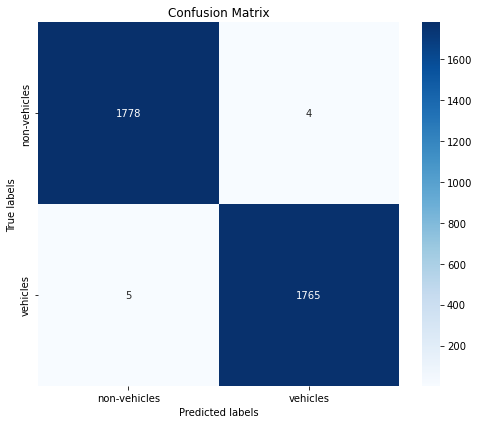

In [78]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

predictions = model.predict(test_set)
predicted_labels = np.argmax(predictions, axis=1)
print(len(predicted_labels))
true_labels = test_set.classes

# Compute confusion matrix
cm = confusion_matrix(np.array(true_labels), predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cm, fmt='d',cmap="Blues", xticklabels=test_set.class_indices.keys(), yticklabels=test_set.class_indices.keys(),annot=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [82]:
accuracy = model.evaluate(X_final_test, verbose=0)
print(f"Accuracy: {accuracy}")

ValueError: in user code:

    File "C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\ASUS\anaconda3\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(32, 2)


In [71]:
cm_df = pd.DataFrame(cm, index=test_set.class_indices.keys(), columns=test_set.class_indices.keys())

print("Confusion Matrix:")
print(cm_df)

Confusion Matrix:
              non-vehicles  vehicles
non-vehicles          1776         6
vehicles                 5      1765
